**Importações**

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

**Preparando os dados**

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/digital-marketing-ml/master/train.csv')
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671


In [17]:
df.dtypes

channelGrouping         object
date                     int64
device                  object
fullVisitorId           uint64
geoNetwork              object
sessionId               object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

Fazendo casting de date, fullVisitorId e visitId para object

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/digital-marketing-ml/master/train.csv', dtype = {'date':object,'fullVisitorId':object,'visitId':object})
df.dtypes

channelGrouping         object
date                    object
device                  object
fullVisitorId           object
geoNetwork              object
sessionId               object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                 object
visitNumber              int64
visitStartTime           int64
dtype: object

Usando json nas colunas device, geoNetwork, trafficSource e totals

In [19]:
colunas_json = ['device','geoNetwork','trafficSource','totals']

for coluna in colunas_json:
  df = df.join(pd.DataFrame([json.loads(linha) for linha in df[coluna]]))

In [20]:
df.drop(colunas_json, axis = 1, inplace = True)

In [21]:
df.adwordsClickInfo

0        {'criteriaParameters': 'not available in demo ...
1        {'criteriaParameters': 'not available in demo ...
2        {'criteriaParameters': 'not available in demo ...
3        {'criteriaParameters': 'not available in demo ...
4        {'criteriaParameters': 'not available in demo ...
                               ...                        
12278    {'criteriaParameters': 'not available in demo ...
12279    {'criteriaParameters': 'not available in demo ...
12280    {'criteriaParameters': 'not available in demo ...
12281    {'criteriaParameters': 'not available in demo ...
12282    {'criteriaParameters': 'not available in demo ...
Name: adwordsClickInfo, Length: 12283, dtype: object

Excluindo a coluna adwordsClickInfo e verificando a quantidade de valors únicos nas outras colunas

In [22]:
df.drop(columns ='adwordsClickInfo', inplace = True )

In [23]:
columns_drop = [coluna for coluna in df.columns if len(df[coluna].unique()) == 1]

In [24]:
columns_drop

['socialEngagementType',
 'browserVersion',
 'browserSize',
 'operatingSystemVersion',
 'mobileDeviceBranding',
 'mobileDeviceModel',
 'mobileInputSelector',
 'mobileDeviceInfo',
 'mobileDeviceMarketingName',
 'flashVersion',
 'language',
 'screenColors',
 'screenResolution',
 'cityId',
 'latitude',
 'longitude',
 'networkLocation',
 'visits']

Excluindo as colunas com apenas um valor

In [25]:
df.drop(columns = columns_drop, inplace = True)

Convertendo as variáveis quantitativas para númeric

In [26]:
vars_quants = ['bounces','hits','newVisits','pageviews','transactionRevenue']

for coluna in vars_quants:
  df[coluna] = pd.to_numeric(df[coluna])

Verificando a variável resposta

In [27]:
print('total de valores da transactionRevenue {}'.format(df.transactionRevenue.shape[0]))
print('valores Nan da transactionRevenue: {}'.format((df.transactionRevenue.isna()).sum()))

total de valores da transactionRevenue 12283
valores Nan da transactionRevenue: 12119


Podemos considerar os valores Nan como usuários que não gastaram nada

In [28]:
df.transactionRevenue.fillna(0, inplace = True)
df.transactionRevenue =df.transactionRevenue / 1000000

In [29]:
df_quant = df.groupby('fullVisitorId', as_index = False)[vars_quants].sum()
df_quant.shape

(9997, 6)

**Treinando o modelo de regressão linear**

In [30]:
y = df_quant.transactionRevenue.copy()
X = df_quant.drop(columns = 'transactionRevenue')
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 50)

In [31]:
reg = LinearRegression()
reg.fit(X_train,y_train)
predict = reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


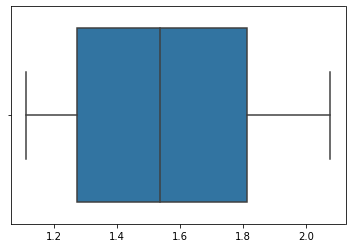

In [32]:
sns.boxplot(predict)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


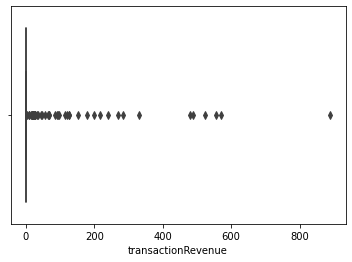

In [33]:
sns.boxplot(y_test)

In [34]:
np.sqrt(mean_squared_error(y_test,predict))

30.22953483309044

In [35]:
np.std(df_quant.transactionRevenue)

25.129905708017944

O modelo está errando mais que o desvio natural da base de dados

**Explorando as métricas de primeira e última visita ao site para melhorar o modelo**

In [36]:
ultimas_visitas = df.groupby('fullVisitorId', as_index = False)['visitNumber'].max()
ultimas_visitas

,fullVisitorId,visitNumber
0,0002365800130207040,1
1,0010286039787739137,1
2,0011056874471185769,1
3,0014443856125569702,1
4,0017260116665815114,6
...,...,...
9992,9996691020299725061,3
9993,9996793353803109760,1
9994,9997125062030599880,1
9995,9997464307347866920,1


In [37]:
usuarios_visitas_unicas = df.drop_duplicates(subset = ['fullVisitorId','visitNumber'])

In [41]:
visitas = pd.merge(ultimas_visitas,usuarios_visitas_unicas, 
                   left_on = ['fullVisitorId','visitNumber'], 
                   right_on =['fullVisitorId','visitNumber'],
                   how = 'left')
visitas.shape

(9997, 31)

In [42]:
primeiras_visitas = df.groupby('fullVisitorId', as_index = False)['visitNumber'].min()
primeiras_visitas.head()

,fullVisitorId,visitNumber
0,0002365800130207040,1
1,0010286039787739137,1
2,0011056874471185769,1
3,0014443856125569702,1
4,0017260116665815114,6


In [43]:
primeiras_visitas.set_index('fullVisitorId', inplace = True)

In [44]:
visitas = visitas.join(primeiras_visitas, how = 'left', on = 'fullVisitorId', rsuffix='_primeira')

In [45]:
visitas = pd.merge(visitas,usuarios_visitas_unicas, left_on = ['fullVisitorId','visitNumber_primeira'],
                   right_on = ['fullVisitorId','visitNumber'], how = 'left', suffixes = ['_ultima','_primeira'])

In [46]:
visitas.head()

,fullVisitorId,visitNumber_ultima,channelGrouping_ultima,date_ultima,sessionId_ultima,visitId_ultima,visitStartTime_ultima,browser_ultima,operatingSystem_ultima,isMobile_ultima,deviceCategory_ultima,continent_ultima,subContinent_ultima,country_ultima,region_ultima,metro_ultima,city_ultima,networkDomain_ultima,campaign_ultima,source_ultima,medium_ultima,keyword_ultima,isTrueDirect_ultima,referralPath_ultima,adContent_ultima,campaignCode_ultima,hits_ultima,pageviews_ultima,bounces_ultima,newVisits_ultima,transactionRevenue_ultima,visitNumber_primeira,channelGrouping_primeira,date_primeira,sessionId_primeira,visitId_primeira,visitNumber_primeira,visitStartTime_primeira,browser_primeira,operatingSystem_primeira,isMobile_primeira,deviceCategory_primeira,continent_primeira,subContinent_primeira,country_primeira,region_primeira,metro_primeira,city_primeira,networkDomain_primeira,campaign_primeira,source_primeira,medium_primeira,keyword_primeira,isTrueDirect_primeira,referralPath_primeira,adContent_primeira,campaignCode_primeira,hits_primeira,pageviews_primeira,bounces_primeira,newVisits_primeira,transactionRevenue_primeira
0,0002365800130207040,1,Social,20160904,0002365800130207040_1472974804,1472974804,1472974804,Edge,Windows,False,desktop,Europe,Eastern Europe,Ukraine,not available in demo dataset,not available in demo dataset,not available in demo dataset,wildpark.net,(not set),youtube.com,referral,NaN,NaN,/yt/about/ru/,NaN,NaN,1,1,1.0,1.0,0.0,1,Social,20160904,0002365800130207040_1472974804,1472974804,1,1472974804,Edge,Windows,False,desktop,Europe,Eastern Europe,Ukraine,not available in demo dataset,not available in demo dataset,not available in demo dataset,wildpark.net,(not set),youtube.com,referral,NaN,NaN,/yt/about/ru/,NaN,NaN,1,1,1.0,1.0,0.0
1,0010286039787739137,1,Organic Search,20160928,0010286039787739137_1475084026,1475084026,1475084026,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,Missouri,Kansas City MO,Kansas City,(not set),(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,4,3,NaN,1.0,0.0,1,Organic Search,20160928,0010286039787739137_1475084026,1475084026,1,1475084026,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,Missouri,Kansas City MO,Kansas City,(not set),(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,4,3,NaN,1.0,0.0
2,0011056874471185769,1,Social,20161205,0011056874471185769_1480996024,1480996024,1480996024,Chrome,Windows,False,desktop,Asia,Southeast Asia,Philippines,not available in demo dataset,not available in demo dataset,not available in demo dataset,pldt.net,(not set),youtube.com,referral,NaN,NaN,/yt/about/,NaN,NaN,2,2,NaN,1.0,0.0,1,Social,20161205,0011056874471185769_1480996024,1480996024,1,1480996024,Chrome,Windows,False,desktop,Asia,Southeast Asia,Philippines,not available in demo dataset,not available in demo dataset,not available in demo dataset,pldt.net,(not set),youtube.com,referral,NaN,NaN,/yt/about/,NaN,NaN,2,2,NaN,1.0,0.0
3,0014443856125569702,1,Social,20161002,0014443856125569702_1475423502,1475423502,1475423502,Opera,Windows,False,desktop,Europe,Eastern Europe,Romania,Bucharest,(not set),Bucharest,rdsnet.ro,(not set),youtube.com,referral,NaN,NaN,/yt/about/ro/,NaN,NaN,1,1,1.0,1.0,0.0,1,Social,20161002,0014443856125569702_1475423502,1475423502,1,1475423502,Opera,Windows,False,desktop,Europe,Eastern Europe,Romania,Bucharest,(not set),Bucharest,rdsnet.ro,(not set),youtube.com,referral,NaN,NaN,/yt/about/ro/,NaN,NaN,1,1,1.0,1.0,0.0
4,0017260116665815114,6,Direct,20170420,0017260116665815114_1492707286,1492707286,1492707286,Safari,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcastbusiness.net,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,2,2,NaN,NaN,0.0,6,Direct,20170420,0017260116665815114_1492707286,1492707286,6,1492707286,Safari,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not a

**Limpando a base de dados**

In [47]:
for coluna in vars_quants:
  visitas.drop(coluna + '_ultima',axis = 1, inplace = True)
  visitas.drop(coluna + '_primeira', axis = 1, inplace = True)

Removendo as variáveis id's

In [48]:
ids = ['visitId_ultima','visitId_primeira','sessionId_primeira','sessionId_ultima']
visitas.drop(columns = ids, inplace = True)

Mantendo apenas as variáveis geográficas da última visita 

In [49]:
geo = ['city_primeira','continent_primeira','country_primeira',
       'metro_primeira','region_primeira',
       'networkDomain_primeira','subContinent_primeira']
visitas.drop(columns = geo, inplace = True)

Criando uma nova coluna com o tempo entre a primeira e a última visita

In [50]:
visitas = pd.merge(visitas,df_quant, left_on=['fullVisitorId'],
              right_on=['fullVisitorId'],how='left')

In [51]:
visitas['tempo_entre_primeira_ultima_visita'] = visitas['visitStartTime_ultima'] - visitas['visitStartTime_primeira']

In [55]:
visitas['ano_ultima'] = pd.to_numeric([data[0:4] for data in visitas.date_ultima])
visitas['mes_ultima'] = pd.to_numeric([data[4:6] for data in visitas.date_ultima])
visitas['dia_ultima'] = pd.to_numeric([data[6:8] for data in visitas.date_ultima])

visitas['ano_primeira'] = pd.to_numeric([data[0:4] for data in visitas.date_primeira])
visitas['mes_primeira'] = pd.to_numeric([data[4:6] for data in visitas.date_primeira])
visitas['dia_primeira'] = pd.to_numeric([data[6:8] for data in visitas.date_primeira])

Adicionando a variável visitas

In [54]:
visits = df.groupby('fullVisitorId', as_index = False).count().visitNumber.values
visitas['visits'] = visits

**Melhorando o modelo**

In [56]:
visitas.drop(columns = 'fullVisitorId', inplace = True)

In [57]:
y = visitas.transactionRevenue.copy()
X = visitas.drop(columns = 'transactionRevenue')

Usando o Label Encoder nas variáveis qualitativas

In [ ]:
vars_quali = visitas.dtypes[visitas.dtypes == object].keys()
for coluna in vars_quali:
  label_encoder = LabelEncoder()
  strings = list(X[coluna].values.astype('str'))
  label_encoder.fit(strings)
  X[coluna] = label_encoder.transform(strings)

In [59]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 50)

In [60]:
model = LinearRegression()
model.fit(X_train,y_train)
predict = model.predict(X_test)

In [61]:
predict[predict < 0] = 0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


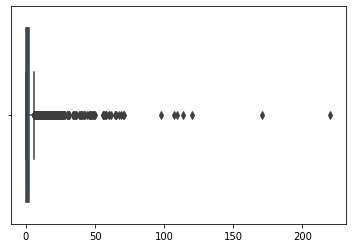

In [62]:
sns.boxplot(predict)

In [63]:
np.sqrt(mean_squared_error(y_test,predict))

27.663606376300667

**Treinando o gradient boosting**

In [64]:
gb = GradientBoostingRegressor(random_state = 49)
gb.fit(X_train,y_train)
gb_predict = gb.predict(X_test)

In [65]:
gb_predict[gb_predict < 0] = 0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


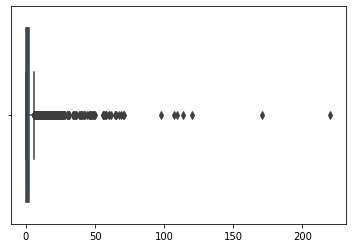

In [66]:
sns.boxplot(predict)

In [67]:
np.sqrt(mean_squared_error(y_test,gb_predict))

28.72750465097226